# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации
## Докшина Елизавета

###### <hr\>
**Общая информация**

**Срок сдачи:** 23 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 23 октября, -4 балла после 06:00 30 октября, -6 баллов после 06:00 6 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, использую timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
изуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Реализация алгоритма

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

In [2]:
N = 16 # put your index here

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
## Задание 1
from sklearn.base import BaseEstimator, ClusterMixin

class Hierarchical(BaseEstimator, ClusterMixin):

    def __init__(self, k, linkage='single'):
        self.k = k # число кластеров
        self.linkage = linkage
        self.dend = []
    
    def distances_recount(self, new_clust, x, y):
        # Пересчет расстояний между кластерами
        
        if self.linkage == 'single':
            self.distances[x] = [min(self.distances[x, k], self.distances[y, k]) for k in xrange(self.n)]
            
        elif self.linkage == 'complete':
            self.distances[x] = [max(self.distances[x, k], self.distances[y, k]) for k in xrange(self.n)]    
            
        elif self.linkage == 'average':
            self.distances[x] = [(self.distances[x][k] * self.sizes[x] + \
                                    self.distances[y][k] * self.sizes[y]) / (self.sizes[x] + self.sizes[y]) \
                                                 for k in xrange(self.n)]        
        self.distances.T[x] = self.distances[x]
        self.distances.T[y] = self.distances[y] = [np.nan for k in xrange(self.n)]
        self.idxs[x] = self.max_label
        self.idxs[y] = np.nan
        

    def merge(self, x, y):
        # Слияние двух кластеров

        if x > y:
            x, y = y, x
            
        self.labels[self.labels == self.idxs[x]] = self.max_label
        self.labels[self.labels == self.idxs[y]] = self.max_label
        self.sizes[x] += self.sizes[y]
        
        self.distances_recount(self.max_label, x, y)
        self.max_label += 1
        
        return self.sizes[x]
              
    def fit(self, X, y=None):    
        # Разбиение на кластеры и подсчет денрограммы
        self.clusters_num = self.n = X.shape[0]
        self.labels = np.arange(self.n)
        self.max_label = self.n
        self.X = X
        self.sizes = np.ones(self.n)
        self.idxs = dict((k, v) for k, v in enumerate(np.arange(self.n)))
        
        self.distances = cdist(X, X)
        for i in xrange(self.distances.shape[0]):
            self.distances[i, i] = np.nan
        
        while self.clusters_num > 1:
            x, y = np.unravel_index(np.nanargmin(self.distances), self.distances.shape) 
            self.dend += [[self.idxs[x], self.idxs[y], self.distances[x, y], self.sizes[x] + self.sizes[y]]]
            self.merge(x, y)          
            
            self.clusters_num -=1
            if self.clusters_num == self.k:
                self.clust_labels = np.copy(self.labels)  

        return self
    
    def predict(self, X):
        return self.clust_labels
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)
    
    def get_dend(self):
        return self.dend

In [5]:
iris = ds.load_iris()
X_iris = iris.data[:100]

X_iris = (X_iris - X_iris.mean(axis=0)) / X_iris.std(axis=0)

# Вызываем алгоритм для Iris с single-linkage

In [6]:
clust = Hierarchical(2, linkage='single')
labels = clust.fit_predict(X=X_iris)

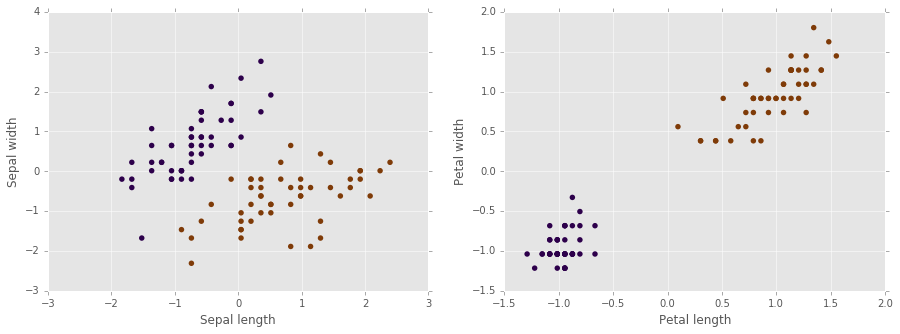

In [7]:
pl.figure(figsize=(15, 5))

pl.subplot(1, 2, 1)
pl.scatter(X_iris[:, 0], X_iris[:, 1], c=labels, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(X_iris[:, 2], X_iris[:, 3], c=labels, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

# Дендрограмма

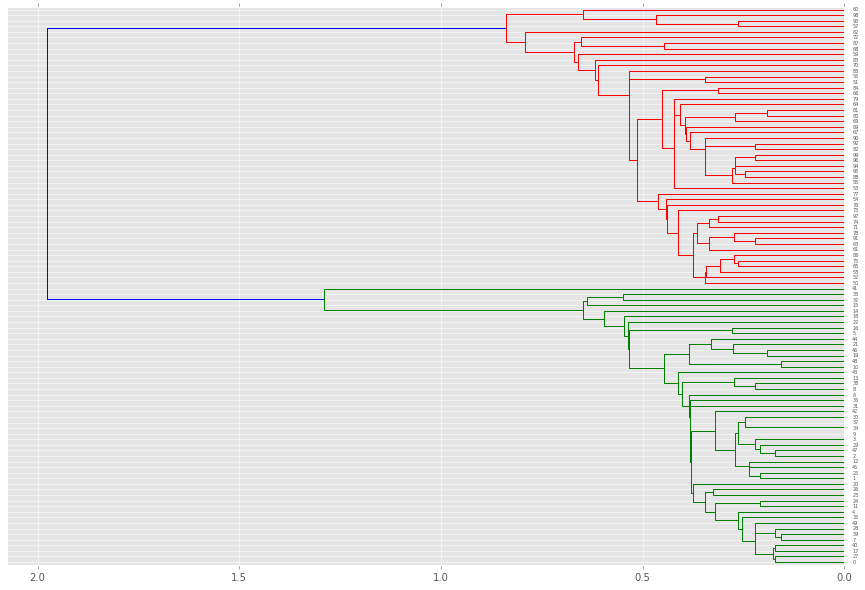

In [8]:
plt.figure(figsize=(15, 10))
d = dendrogram(clust.get_dend(), orientation='left')

# Adjusted Rand Index

In [9]:
X_iris = iris.data[:100]
Y_iris = iris.target[:100]

In [10]:
pred_iris = Hierarchical(2, linkage='single').fit_predict(X_iris)
print "With single-linkage Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(Y_iris, pred_iris)

pred_iris = Hierarchical(2, linkage='complete').fit_predict(X_iris)
print "With complete-linkage Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(Y_iris, pred_iris)

pred_iris = Hierarchical(2, linkage='average').fit_predict(X_iris)
print "With average-linkage Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(Y_iris, pred_iris)

With single-linkage Adjusted Rand index for iris is: 1.00
With complete-linkage Adjusted Rand index for iris is: 1.00
With average-linkage Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

# 2. Критерий качества

In [11]:
from itertools import product, combinations

In [12]:
num_clasters = np.arange(1, 10)
linkages = ['single', 'complete', 'average']
p = product(num_clasters, linkages)

parametrs = dict((k, v) for k, v in enumerate(p))

In [13]:
ticks = []
for p in parametrs.values():
    ticks.append('{}: {}'.format(p[0], p[1]))

In [14]:
def DunnIndex(X, labels):
    labels_set = set(labels)
    if len(labels_set) == 1:
        return 0
    
    diam = np.max([np.max(cdist(X[labels == lbl], X[labels == lbl])) for lbl in labels_set])
    delta = np.min([np.min(cdist(X[labels == lbl1], X[labels == lbl2])) \
                    for lbl1, lbl2 in combinations(labels_set, 2)])        
    return delta / diam

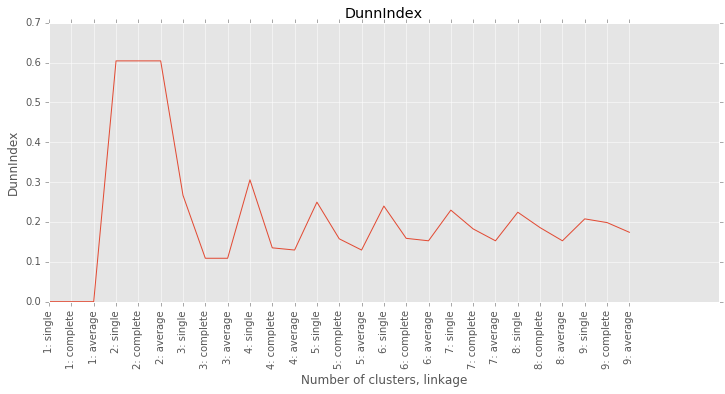

For a given set optimal parametrs is:
2 clusters, single-linkage
2 clusters, complete-linkage
2 clusters, average-linkage


In [15]:
num_clasters = np.arange(1, 10)
criteria = np.zeros(len(parametrs))

for i, num in enumerate(parametrs):
    model = Hierarchical(k=parametrs[num][0], linkage=parametrs[num][1])
    y = model.fit_predict(X_iris)
    criteria[i] = DunnIndex(X_iris, y)
    
pl.figure(figsize=(12, 5))
pl.plot(np.arange(len(parametrs)), criteria)
pl.title("DunnIndex")
pl.ylabel("DunnIndex")
pl.xlabel("Number of clusters, linkage")

plt.xticks(xrange(len(ticks)), ticks, rotation=90)
pl.show()

opt = max(criteria)

print('For a given set optimal parametrs is:')
for i in xrange(len(parametrs)):
    if criteria[i] == opt:
        print('{} clusters, {}-linkage'.format(parametrs.values()[i][0], parametrs.values()[i][1]))

# 3. Применение на реальных данных

In [16]:
# Исходные данные
df_countries = pd.read_csv('WDIData.csv')

In [17]:
# Убираем данные, которые не относятся к конкретным странам (иначе они выделяются в отдельные кластеры)
df_countries = df_countries.iloc[df_countries.loc[df_countries['Country Name']=='Afghanistan'].index[0]:]

In [18]:
# Фиксируем год
df = df_countries[['Country Name', 'Indicator Code', '2011']]
df = df.set_index(['Country Name', 'Indicator Code'])
df = df.unstack()

In [19]:
# Нормализуем
df = (df - df.mean(axis=0)) / df.std(axis=0)
df = df.fillna(0)

In [20]:
# Убираем плохо заполненные столбцы
all_values = np.sort((df ** 2).sum().values)
min_value = all_values[int(df.shape[1] * 0.7)]

good_df = df[df.columns[(df ** 2).sum().values > min_value]]

In [21]:
# Переходим в двумерное пространство
from sklearn.manifold import TSNE
transform = TSNE(n_components=2)
embedded = transform.fit_transform(good_df.values)

In [22]:
# Запускаем алгоритм
model = Hierarchical(k=8, linkage='complete')
mylabels = model.fit_predict(good_df.values)

In [23]:
# Меняем метки на 1, 2, ...
mydict = {}
for i, label in enumerate(set(mylabels)):
    mydict.update({label : i + 1})
for i in xrange(mylabels.shape[0]):
    mylabels[i] = mydict[mylabels[i]]

In [24]:
# Вывод стран по кластерам
pd.options.mode.chained_assignment = None
good_df.loc[:, 'label'] = mylabels

for label, group in good_df.groupby('label'):
    print('Cluster #{}'.format(label))    
    print(group.index.tolist())
    print('='*20)

Cluster #1
['France', 'Germany', 'Italy', 'Japan', 'Netherlands', 'Spain', 'Switzerland', 'United Kingdom']
Cluster #2
['Afghanistan', 'Algeria', 'Angola', 'Bangladesh', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Egypt, Arab Rep.', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Jordan', 'Kenya', 'Lao PDR', 'Lebanon', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Philippines', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Sri Lanka', 'Sudan', 'Suriname', 'Swaziland', 'Syrian Arab Republic', 'Tanzania', 'Timor-Leste', 'Togo', 'Tunisia', 'Uganda', 'West Bank and Gaza', 'Y

# 4. Объяснение разбиения
- Франция, Германия, Италия и тд - богатые страны с высоким уровнем жизни;
- Афганистан и тд - африканские, азиатские и ближневосточные страны с плохой экономикой и частыми войнами;
- Албания, Россия и тд - страны с хорошим уровнем жизни, состоят в международных организациях;
- Китай - огромное население, крупная промышленность;
- США - флагман мировой экономики;
- Индонезия, Въетнам - Юго-Восточная Азия;
- Индия - огромное население, хорошая экономика;
- Иран - богатая азиатская страна.

США, Китай и Индия - самые экономически развитые страны, поэтому выделяются в отдельные кластеры.

## Визуализация

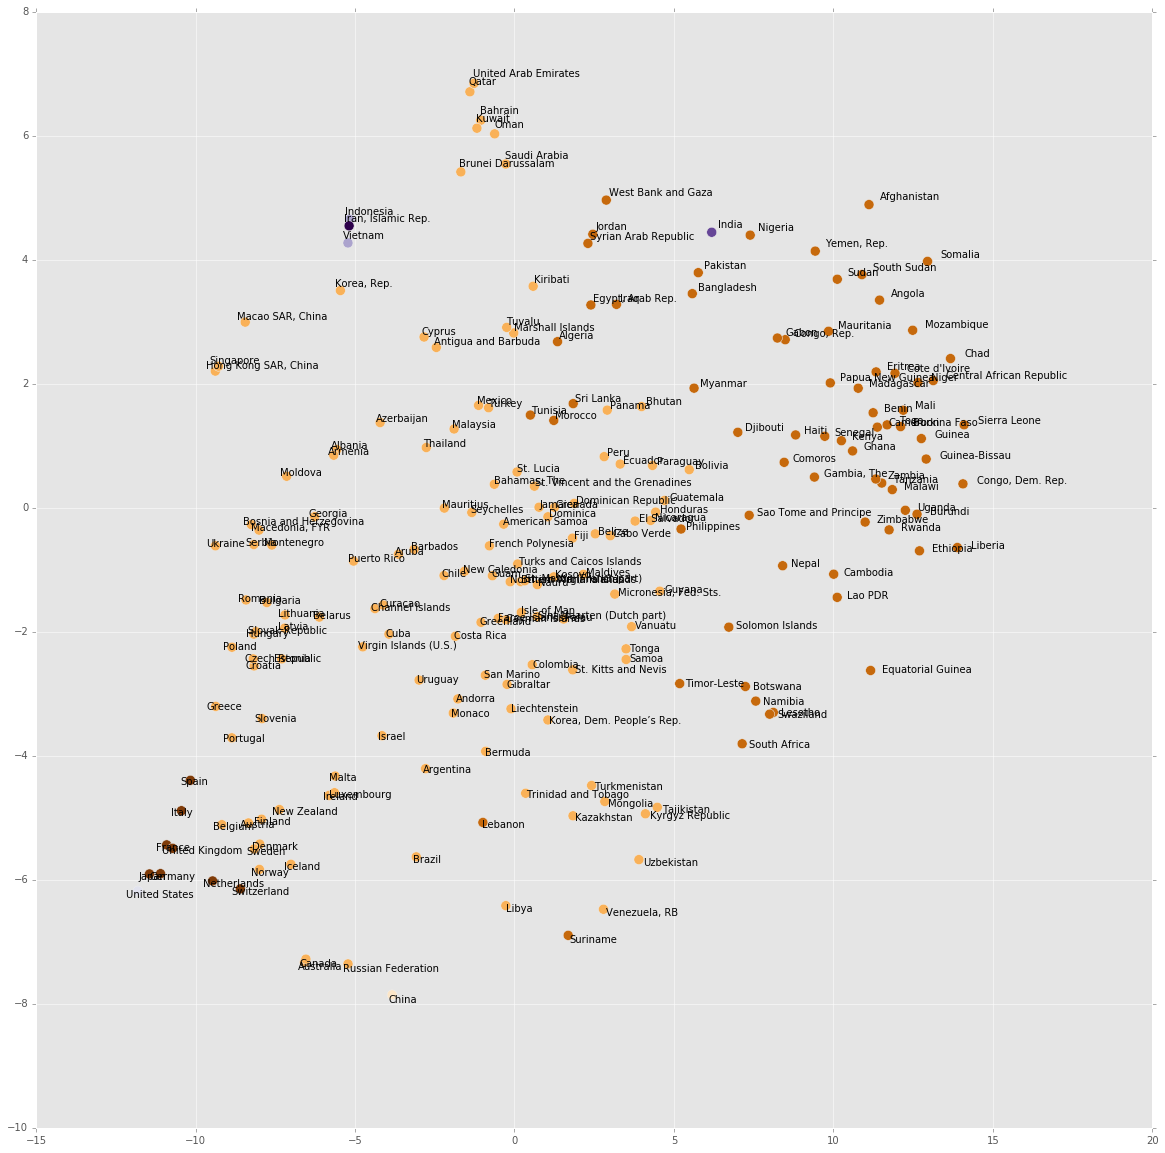

In [25]:
import sys
reload(sys)
sys.setdefaultencoding('UTF8')

plt.figure(figsize=(20, 20))
matplotlib.rcParams.update({'font.size': 10})

plt.scatter(embedded[:,0], embedded[:,1], c=mylabels, cmap=pl.cm.PuOr, s=100)
for i in xrange(good_df.shape[0]):
    print(good_df.index[i])
    plt.annotate(str(good_df.index[i]), xy = embedded[i], textcoords='offset points')

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.